In [71]:
# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Manipulation
import numpy as np
import pandas as pd

# Loading Data
import os
import gensim.downloader as api
from gensim.models import KeyedVectors

# Trie for fast lookup
from datrie import BaseTrie
import string

# Dimensionality Reduction
from sklearn.decomposition import PCA

# Clustering
from sklearn.cluster import KMeans

# Grid Search
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, adjusted_rand_score

In [2]:
# Import Google News 300 Word2Vec dataset
w2v_model: KeyedVectors = api.load('word2vec-google-news-300')

In [3]:
# Make a Trie for O(1) lookup of containment of words
t = BaseTrie(string.ascii_lowercase)

for x in w2v_model.index_to_key:
    t[x] = True

In [4]:
# Define a helper function to get the vector of a given word
def vec(str):
    return w2v_model.vectors[w2v_model.key_to_index[str]]

In [5]:
LEN_DATA = 50

list_dirnames = []
list_data = []
for subdir, dirs, files in os.walk('./BATS_3.0'):
    for file in files:
        if file.endswith('.txt'):
            list_dirnames.append(file)
            list_data.append(pd.read_csv(os.path.join(subdir, file), sep='\t', header=None))

# Add pair_id, which uniquely identifies each pair, and relation_id, which identifies the dataset
full_df = pd.concat([ df.assign(pair_id=range(LEN_DATA*i, LEN_DATA*(i+1)), relation_id=i) for i, df in enumerate(list_data) ])

# Remove all but the first result for the second element of each pair
full_df[1] = full_df[1].str.split('/', expand=True)[0]

# Remove all pairs where one of the words are not in the word2vec dataset
full_df = full_df[full_df[0].apply(t.__contains__) & full_df[1].apply(t.__contains__)]

In [6]:
word_pair_vecs = np.vstack(full_df[0].apply(vec)) - np.vstack(full_df[1].apply(vec))

In [104]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('dim_reduce', PCA(random_state=42)),
    ('cluster', KMeans(n_clusters=40, random_state=42))
])

grid_params = {
    'dim_reduce__n_components': [ 4, 6, 8, 12, 16, 24, 32, 48, 64, 96, 128, 160, 256, 300 ],
    'cluster__n_init': range(10, 100, 10)
}

grid = GridSearchCV(pipe, grid_params, scoring=make_scorer(adjusted_rand_score), cv=[(slice(None), slice(None))], n_jobs=-1).fit(word_pair_vecs, full_df['relation_id'])

In [105]:
results = pd.DataFrame(grid.cv_results_)[[ 'param_dim_reduce__n_components', 'param_cluster__n_init', 'mean_test_score' ]]

pivot_results = results.pivot(index='param_dim_reduce__n_components', columns='param_cluster__n_init', values='mean_test_score')

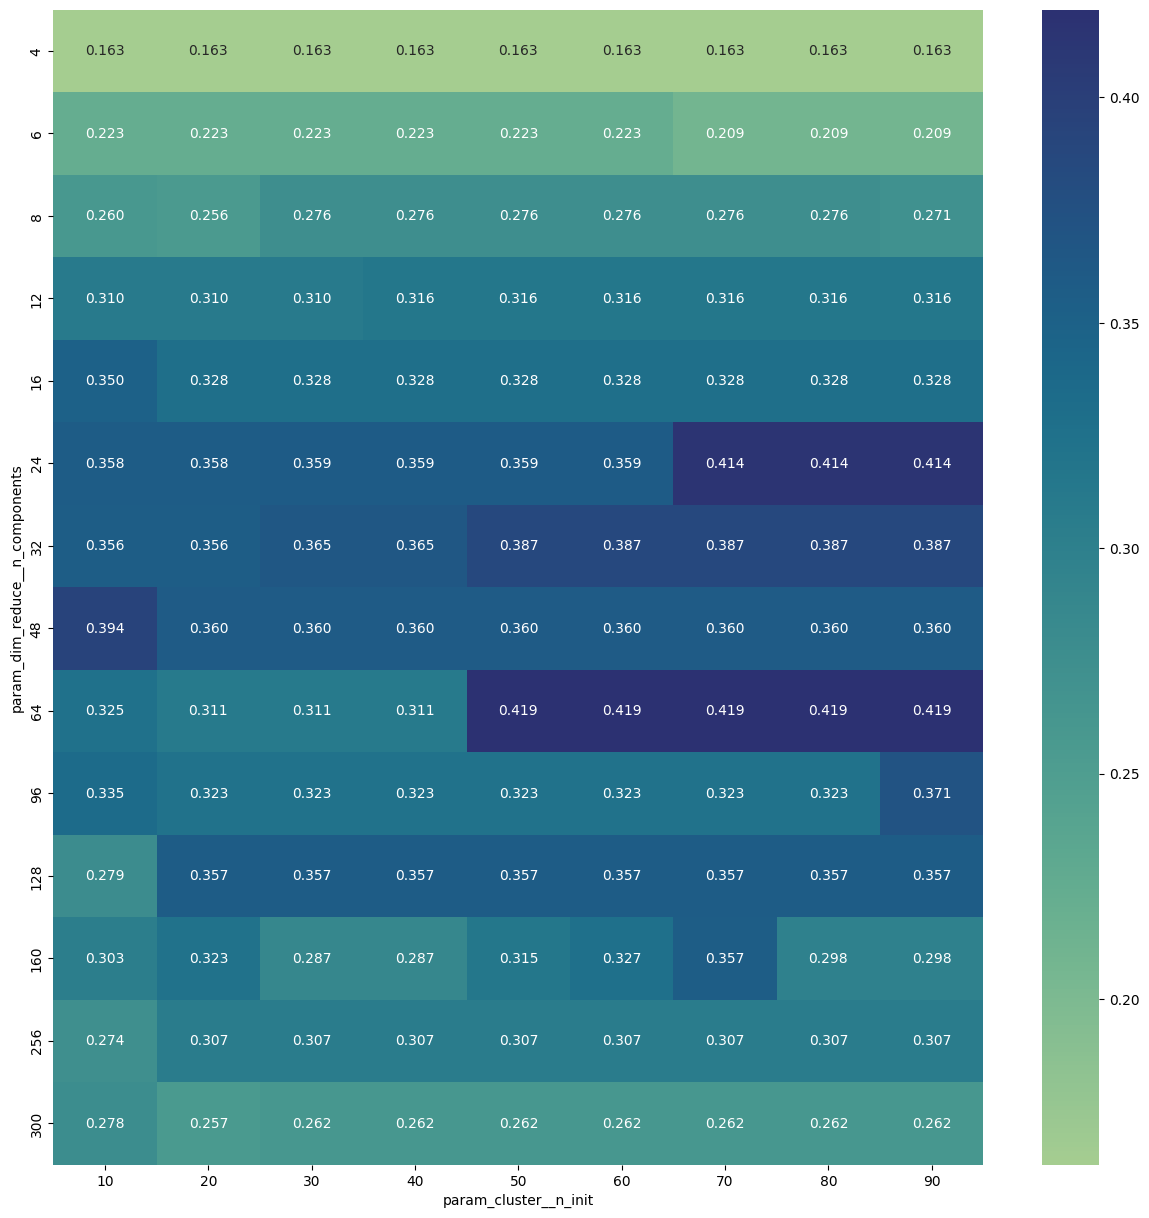

In [106]:
fig, ax = plt.subplots(figsize=(15, 15))

sns.heatmap(pivot_results, cmap='crest', annot=True, fmt='.3f');

In [110]:
labels = grid.predict(word_pair_vecs)

In [111]:
adjusted_rand_score(full_df['relation_id'], labels)

0.4194115924129796

In [112]:
relationship_conds = [ (id, full_df['relation_id'] == id) for id in range(40) ]
best_clusters = []
for id, cond in relationship_conds:
    best_clusters.append(pd.Series(labels[cond]).value_counts().index[0])

In [113]:
best_clusters

[6,
 28,
 36,
 6,
 16,
 29,
 5,
 16,
 35,
 15,
 10,
 20,
 27,
 8,
 9,
 9,
 17,
 7,
 37,
 26,
 38,
 16,
 38,
 38,
 11,
 38,
 1,
 11,
 2,
 18,
 19,
 39,
 21,
 31,
 13,
 32,
 4,
 25,
 38,
 24]